Notebook objective: Train & test mixed effects linear model. Goal is to compare performance, SHAP values & fixed effects with GPB.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import gpboost as gpb

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Set print options
np.set_printoptions(suppress=True, precision=6, edgeitems = 7)
pd.options.display.float_format = '{:.6f}'.format
pd.set_option('display.max_columns', None)

## Preprocessing

In [3]:
random_state = 1923

In [4]:
# Read data
df = pd.read_csv("./OutputData/training_data.csv")

In [5]:
# Split features, groupings and target
X = df.drop(["life_expectancy", "country", "year"], axis = 1)
G = df[["country", "year"]]
y = df.life_expectancy

In [6]:
# Randomly select 25 countries for the testing set
rng = np.random.default_rng(random_state)
test_countries = rng.choice(G.country, size = 25)
test_countries

array(['Guyana', 'Serbia', 'Turkmenistan', 'Samoa', 'Poland',
       'Sao Tome and Principe', 'Latvia', 'Solomon Islands', 'Bhutan',
       'Armenia', 'Mauritania', 'Mozambique', 'Malawi',
       'Dominican Republic', 'Uganda', 'Madagascar', 'Sweden',
       'Central African Republic', 'Zimbabwe', 'Mongolia', 'El Salvador',
       'Argentina', 'Comoros', 'Israel', 'Angola'], dtype=object)

In [7]:
# Split train-test
G_test = G[G["country"].isin(test_countries)]
X_test = X[X.index.isin(G_test.index)]
y_test = y[G_test.index]

G_train = G[~G["country"].isin(test_countries)]
X_train = X[X.index.isin(G_train.index)]
y_train = y[G_train.index]

In [8]:
# Scale features 0-1
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# Add intercept
X_train = np.hstack(
    (X_train, np.ones((len(X_train), 1)))
)
X_test = np.hstack(
    (X_test, np.ones((len(X_test), 1)))
)

In [10]:
# Get back feature names
feature_name = X.columns.values.tolist()
feature_name.append("intercept")
X_train = pd.DataFrame(X_train, columns = feature_name)
X_test = pd.DataFrame(X_test, columns = feature_name)

## Testing & diagnostics

In [12]:
# Create random effects model
train = gpb.Dataset(X_train, y_train, feature_name = feature_name)
test = gpb.Dataset(X_test, y_test, feature_name = feature_name)

gp_model = gpb.GPModel(
        group_data = G_train,
        likelihood = "gaussian",
        seed = random_state
    )

In [13]:
# Train mixed effects model
gp_model.fit(X = X_train, y = y_train, params = {"std_dev": True})

In [14]:
# Make predictions on test data
preds = gp_model.predict(X_pred = X_test, group_data_pred = G_test, predict_var = True)["mu"]

In [15]:
# Calculate MSE, RMSE, MAPE
print("MSE:")
print(round(mean_squared_error(y_test, preds), 4))

print("RMSE:")
print(round(mean_squared_error(y_test, preds, squared = False), 4))

print("MAPE:")
print(round(mean_absolute_percentage_error(y_test, preds), 4))

MSE:
42.0343
RMSE:
6.4834
MAPE:
0.0865


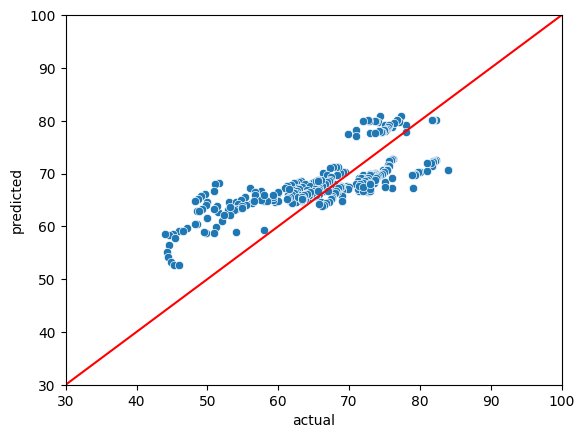

In [16]:
# Plot predicted vs. actual
_ = sns.scatterplot(x = y_test,  y = preds)
_ = plt.plot([30, 100], [30, 100], c = "red")
_ = plt.xlim(30, 100)
_ = plt.ylim(30, 100)
_ = plt.xlabel("actual")
_ = plt.ylabel("predicted")

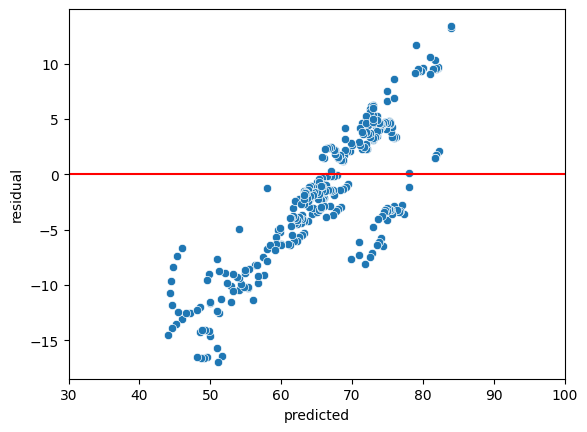

In [17]:
# Predicted vs residual
resids = y_test - preds
_ = sns.scatterplot(x = y_test, y= resids)
_ = plt.plot([30, 100], [0, 0], c = "red")
_ = plt.xlim(30, 100)
#_ = plt.ylim(-30, 30)
_ = plt.xlabel("predicted")
_ = plt.ylabel("residual")

The predictions vary more & perform better than GPBoost. Pretty much right between LGBM and GPBoost.

In [18]:
# Get fitted values
fitted = gp_model.predict(
    X_pred = X_train, 
    group_data_pred = G_train, 
    predict_var = True)["mu"]

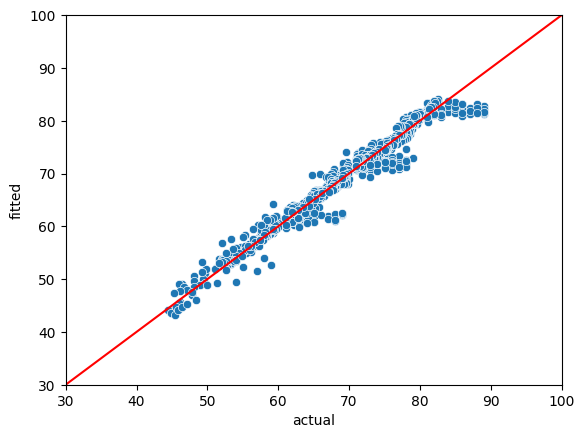

In [19]:
# Plot fitted vs. actual
_ = sns.scatterplot(x = y_train,  y = fitted)
_ = plt.plot([30, 100], [30, 100], c = "red")
_ = plt.xlim(30, 100)
_ = plt.ylim(30, 100)
_ = plt.xlabel("actual")
_ = plt.ylabel("fitted")

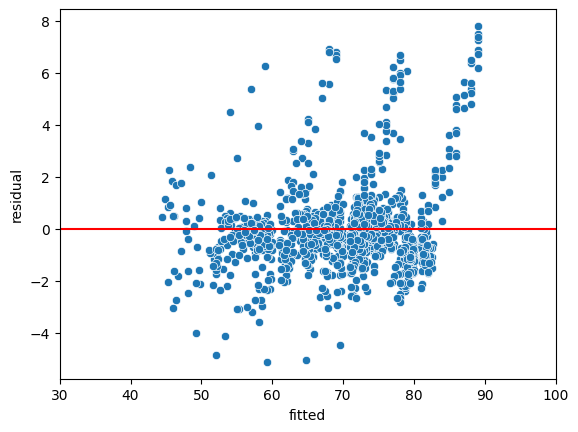

In [20]:
# Plot fitted vs. residual
fitted_resids = y_train - fitted
_ = sns.scatterplot(x = y_train, y= fitted_resids)
_ = plt.plot([30, 100], [0, 0], c = "red")
_ = plt.xlim(30, 100)
#_ = plt.ylim(-30, 30)
_ = plt.xlabel("fitted")
_ = plt.ylabel("residual")

The fitted values are very close to actual, but there are peculiar residual patterns unlike GPBoost.

## Inference

In [21]:
gp_model.summary()

Model summary:
     Log-lik         AIC         BIC
-2851.470000 5742.950000 5846.780000
Nb. observations: 1328
Nb. groups: 108 (country), 16 (year)
-----------------------------------------------------
Covariance parameters (random effects):
              Param.  Std. dev.
Error_term  2.779900   0.113200
country    33.048500   4.539600
year        0.674700   0.266500
-----------------------------------------------------
Linear regression coefficients (fixed effects):
                                    Param.  Std. dev.    z value  P(>|z|)
alcohol                          -0.716100   0.624200  -1.147200 0.251300
percentage_expenditure           -2.758400   2.603000  -1.059700 0.289300
hepatitis_b                       0.189500   0.257800   0.735200 0.462200
measles                          -0.413000   1.012200  -0.408000 0.683200
bmi                               0.032400   0.285400   0.113400 0.909700
polio                            -0.139100   0.277500  -0.501200 0.616200
total_exp

In [22]:
# Get model parameters for SHAP
coefs = gp_model.get_coef().iloc[:-1, :-1].values.flatten()
intercept = gp_model.get_coef().iloc[:-1, -1].values

In [23]:
# Get data parameters for SHAP
X_train_no_intercept = X_train.drop("intercept", axis = 1)
means = X_train_no_intercept.mean().values
covs = X_train_no_intercept.cov().values

In [24]:
# Get SHAP values
explainer = shap.LinearExplainer(
    (coefs, intercept), 
    (means, covs)
)
explainer.expected_value = explainer.expected_value[0] # To fix slicing issue with some SHAP plots
shap_values = explainer(X_train_no_intercept)

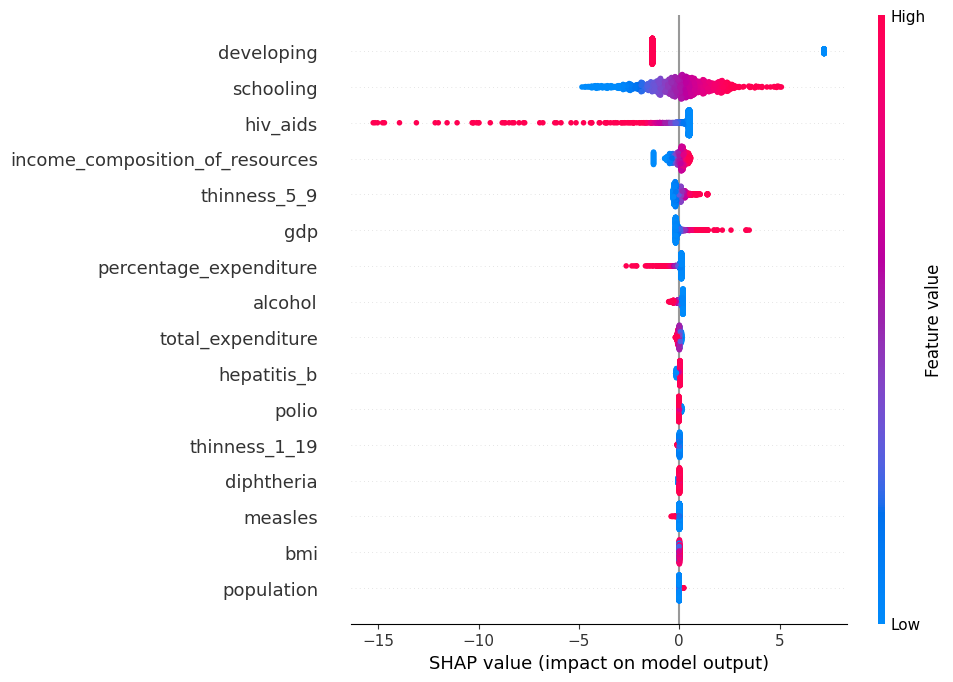

In [25]:
# SHAP summary of all features
shap.plots.beeswarm(shap_values, max_display = 20)

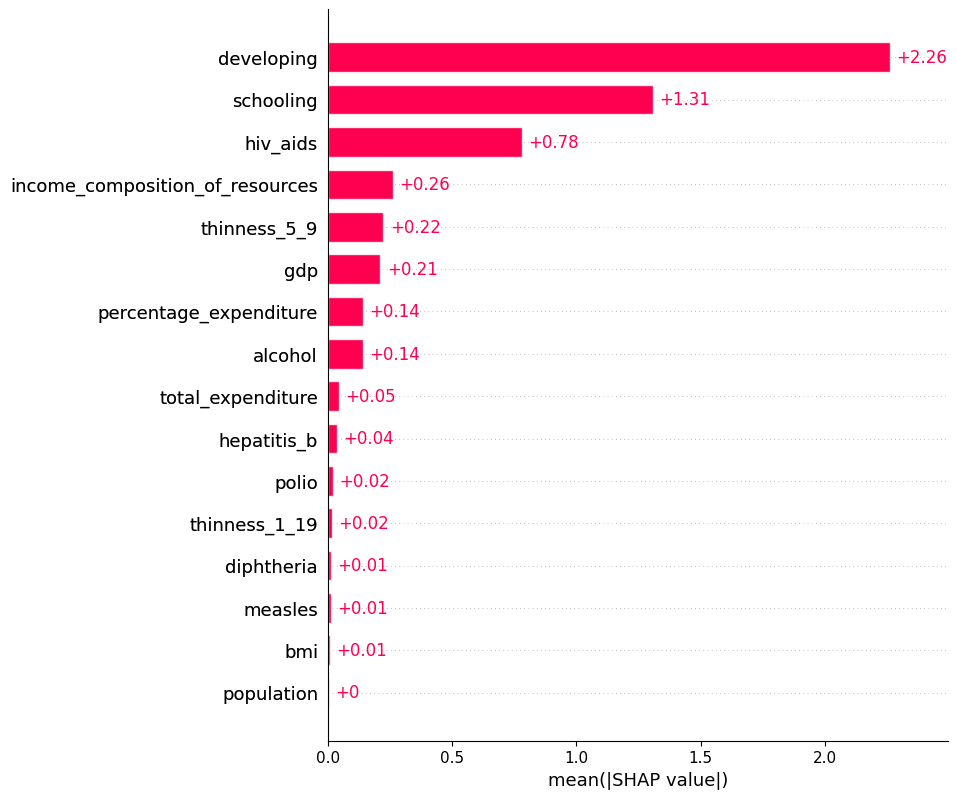

In [26]:
shap.plots.bar(shap_values, max_display = 20)

Interestingly, LMM estimates binary developing country indicator to be the top predictor, which has a small but discriminatory effect in LGBM, and is meaningless in GPB. The country level random effect may make the developing country indicator redundant in GPB, but why not in LMM?

Other than that, schooling, HIV and HDI are the significant & discriminatory predictors. Thinness, GDP, healthcare expenditure, alcohol have a small but discriminatory impact, especially for extreme observations. HIV has a huge effect on extreme values, as expected.

The LMM model still attributes sizeable & significant effects to some fixed predictors, and performs much better than GPBoost on left-out groups. This suggests something about the booster + random effect combination prevents the booster component from learning fixed effects to a full extent.